In [1]:
import torch
# from __future__ import absolute_import
# from __future__ import print_function

from itertools import product

import argparse
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

import gym
import torch.optim as optim
from matplotlib import pylab as plt

In [2]:
from algorithms.reinforce import REINFORCE
from algorithms.a2c import A2C
from algorithms.relax import RELAX

In [3]:
def get_z_tilde_z_samples_params(logits):  # logits = log P(b | theta)
    u = torch.rand_like(logits, device=logits.device)
    v = torch.rand_like(logits, device=logits.device)
    z = logits - torch.log(-torch.log(u))
    samples = torch.argmax(z)

    tilde_z = -torch.log(-torch.log(v)/torch.exp(logits) -
                         torch.log(v)[samples])
    tilde_z[samples] = -torch.log(-torch.log(v))[samples]

    return z, tilde_z, samples

In [4]:
# import torch
# import torch.nn as nn
# from torch.distributions import Categorical
# from icecream.icecream import ic


# class RELAX(nn.Module):

#     def __init__(self, env, hidden_size=128, gamma=.99, random_seed=None):
#         """
#         Assumes fixed continuous observation space
#         and fixed discrete action space (for now)

#         :param env: target gym environment
#         :param gamma: the discount factor parameter for expected reward function :float
#         :param hidden_size: hiddens size for actor and critic hidden layer
#         :param random_seed: random seed for experiment reproducibility :float, int, str
#         """
#         super().__init__()

#         if random_seed:
#             torch.manual_seed(random_seed)

#         self.env = env
#         self.gamma = gamma
#         self.hidden_size = hidden_size
#         self.in_size = len(env.observation_space.sample().flatten())
#         self.out_size = self.env.action_space.n

#         self.actor = nn.Sequential(
#             nn.Linear(self.in_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, self.out_size)
#         ).double()

#         self.critic = nn.Sequential(
#             nn.Linear(self.in_size + self.out_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, 1)
#         ).double()

#     def train_env_episode(self, render=False):
#         """
#         Runs one episode and collects critic values, expected return,
#         :return: A tensor with total/expected reward, critic eval, and action information
#         """
#         rewards = []
#         critic_vals = []
#         critic_z_vals = []
#         action_lp_vals = []

#         observation, _ = self.env.reset()
#         done = False
#         while not done:
#             if render:
#                 self.env.render()

#             observation = torch.from_numpy(observation).double()

#             action_logits = self.actor(observation)

#             z, tilde_z, action = get_z_tilde_z_samples_params(action_logits)

#             action_log_prob = F.log_softmax(action_logits)[action]

#             pred = torch.squeeze(self.critic(
#                 torch.cat([observation, tilde_z])).view(-1))
#             pred_z = torch.squeeze(self.critic(
#                 torch.cat([observation, z])).view(-1))

#             action_lp_vals.append(action_log_prob)
#             critic_vals.append(pred)
#             critic_z_vals.append(pred_z)

#             observation, reward, done, _, _ = self.env.step(action.item())
#             rewards.append(torch.tensor(reward).double())

#         with torch.no_grad():
#             total_reward = sum(rewards).item()


#         for t_i in range(len(rewards)):
#             G = 0
#             for t in range(t_i, len(rewards)):
#                 G += rewards[t] * (self.gamma ** (t - t_i))
#             rewards[t_i] = G

#         def f(inp):
#             return torch.stack(tuple(inp), 0)

#         rewards = f(rewards)
#         rewards = (rewards - torch.mean(rewards)) / \
#             (torch.std(rewards) + .000000000001)

#         return rewards, f(critic_vals), f(critic_z_vals), f(action_lp_vals), total_reward

#     def compute_loss(self, action_p_vals, G, V, V_z):
#         """
#             Compute critic, actor losses and critic gradients to backward it
#         """
#         assert len(action_p_vals) == len(G) == len(V)
#         advantage = G - V.detach()
#         action_grads = torch.autograd.grad(
#             torch.sum(action_p_vals*(G - V)), self.actor.parameters(), create_graph=True, retain_graph=True
#         )

#         all_action_grads = tuple(0 for _ in range(
#             len(list(self.actor.parameters()))))
#         critic_part = 0

#         num_steps = 0
#         for log_p, reward, v, v_z in zip(action_p_vals, G, V, V_z):
#             num_steps += 1
#             diff = reward - v
#             cur_grads = torch.autograd.grad(
#                 log_p, self.actor.parameters(), create_graph=True, retain_graph=True
#             )
#             V_grads = torch.autograd.grad(
#                 v, self.actor.parameters(), create_graph=True, retain_graph=True
#             )
#             V_z_grads = torch.autograd.grad(
#                 v_z, self.actor.parameters(), create_graph=True, retain_graph=True
#             )

#             for g, V_grad, V_z_grad in zip(cur_grads, V_grads, V_z_grads):
#                 critic_part += ((g*diff + V_z_grad - V_grad)**2).mean()

#             all_action_grads = tuple(g + cur_g*diff + V_z_grad - V_grad for g, cur_g, V_grad, V_z_grad in zip(all_action_grads,
#                                                                                                               cur_grads, V_grads, V_z_grads))

#         critic_part = critic_part / num_steps

#         action_grads = all_action_grads
#         return -(torch.sum(action_p_vals * advantage)), critic_part, action_grads

#     def train_and_backward_episode(self, critic_optim, actor_optim):
#         """
#             Runs environment episode, compute total reward 
#             and optimize actor and critic networks by one gradient step
#             :return: total reward
#         """
#         critic_optim.zero_grad()
#         actor_optim.zero_grad()

#         rewards, critic_vals, critic_z_vals, action_lp_vals, total_reward = self.train_env_episode(
#             render=False)

#         _, l_critic, grads = self.compute_loss(
#             action_p_vals=action_lp_vals, G=rewards, V=critic_vals, V_z=critic_z_vals)

#         l_critic.backward()
#         critic_optim.step()
#         critic_optim.zero_grad()

#         actor_optim.zero_grad()
#         for p, g in zip(self.actor.parameters(), grads):
#             p.backward(-g.detach())

#         actor_optim.step()

#         return total_reward

In [5]:
# import torch
# import torch.nn as nn
# from torch.distributions import Categorical
# from icecream.icecream import ic

# class A2C(nn.Module):

#     def __init__(self, env, hidden_size=256, gamma=.99, random_seed=None):
#         super().__init__()

#         if random_seed:
#             torch.manual_seed(random_seed)

#         self.env = env
#         self.gamma = gamma
#         self.hidden_size = hidden_size
#         self.in_size = len(env.observation_space.sample().flatten())
#         self.out_size = self.env.action_space.n

#         self.actor = nn.Sequential(
#             nn.Linear(self.in_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, self.out_size)
#         ).double()

#         self.critic = nn.Sequential(
#             nn.Linear(self.in_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, 1)
#         ).double()

#     def train_env_episode(self, render=False):
#         rewards = []
#         critic_vals = []
#         action_lp_vals = []

#         # Run episode and save information

#         observation, _ = self.env.reset()
#         done = False
#         while not done:
#             if render:
#                 self.env.render()

#             observation = torch.from_numpy(observation).double()

#             # Get action from actor
#             action_logits = self.actor(observation)

#             dist = Categorical(logits=action_logits)
#             action = dist.sample()

#             # Get action probability
#             #action_log_prob = action_logits[action]
#             action_log_prob = dist.log_prob(action)

#             # Get value from critic
#             pred = torch.squeeze(self.critic(observation).view(-1))
#             #pred = pred*0

#             # Write prediction and action/probabilities to arrays
#             action_lp_vals.append(action_log_prob)
#             critic_vals.append(pred)

#             # Send action to environment and get rewards, next state

#             observation, reward, done, _, _ = self.env.step(action.item())
#             rewards.append(torch.tensor(reward).double())

#         with torch.no_grad():
#             total_reward = sum(rewards).item()

#         # Convert reward array to expected return and standardize
#         for t_i in range(len(rewards)):
#             G = 0
#             for t in range(t_i, len(rewards)):
#                 G += rewards[t] * (self.gamma ** (t - t_i))
#             rewards[t_i] = G

#         # Convert output arrays to tensors using torch.stack
#         def f(inp):
#             return torch.stack(tuple(inp), 0)

#         # Standardize rewards
#         rewards = f(rewards)
#         rewards = (rewards - torch.mean(rewards)) / (torch.std(rewards) + .000000000001)

#         return rewards, f(critic_vals), f(action_lp_vals), total_reward

#     def test_env_episode(self, render=True):
#         observation, _ = self.env.reset()
#         rewards = []
#         done = False
#         while not done:

#             if render:
#                 self.env.render()

#             observation = torch.from_numpy(observation).double()

#             # Get action from actor
#             action_logits = self.actor(observation)
#             action = Categorical(logits=action_logits).sample()

            
#             observation, reward, done, _, _ = self.env.step(action.item())
#             rewards.append(reward)

#         return sum(rewards)

#     @staticmethod
#     def compute_loss(action_p_vals, G, V, critic_loss=nn.MSELoss()):
#         assert len(action_p_vals) == len(G) == len(V)
#         advantage = G - V.detach()
#         return -(torch.sum(action_p_vals * advantage)), ((G - V)**2).mean()#critic_loss(G, V)

#     def train_and_backward_episode(self, critic_optim, actor_optim):
#         critic_optim.zero_grad()
#         actor_optim.zero_grad()

#         rewards, critic_vals, action_lp_vals, total_reward = self.train_env_episode(render=False)

#         l_actor, l_critic = self.compute_loss(action_p_vals=action_lp_vals, G=rewards, V=critic_vals)

#         l_actor.backward()
#         l_critic.backward()

#         actor_optim.step()
#         critic_optim.step()

#         return total_reward


In [6]:
# class REINFORCE:
#     def __init__(self, env, hidden_size=128, gamma=.99, random_seed=None):
#         super().__init__()

#         if random_seed:
#             torch.manual_seed(random_seed)

#         self.env = env
#         self.gamma = gamma
#         self.hidden_size = hidden_size
#         self.in_size = len(env.observation_space.sample().flatten())
#         self.out_size = self.env.action_space.n

#         self.actor = nn.Sequential(
#             nn.Linear(self.in_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, self.out_size)
#         ).double()

#     def train_env_episode(self, render = False):
#         """
#         Runs one episode and collects critic values, expected return,
#         :return: A tensor with total/expected reward, and action information
#         """
#         rewards = []
#         action_lp_vals = []
        
#         observation, _ = self.env.reset()
#         done = False
#         while not done:
#             if render:
#                 self.env.render()

#             observation = torch.from_numpy(observation).double()

#             action_logits = self.actor(observation)

#             dist = Categorical(logits=action_logits)
#             action = dist.sample()

#             #action_log_prob = action_logits[action]
#             action_log_prob = dist.log_prob(action)

#             action_lp_vals.append(action_log_prob)

#             observation, reward, done, _, _ = self.env.step(action.item())
#             rewards.append(torch.tensor(reward).double())

#         with torch.no_grad():
#             total_reward = sum(rewards).item()

#         # Convert reward array to expected return and standardize
#         for t_i in range(len(rewards)):
#             G = 0
#             for t in range(t_i, len(rewards)):
#                 G += rewards[t] * (self.gamma ** (t - t_i))
#             rewards[t_i] = G

#         # Convert output arrays to tensors using torch.stack
#         def f(inp):
#             return torch.stack(tuple(inp), 0)

#         # Standardize rewards
#         rewards = f(rewards)
#         rewards = (rewards - torch.mean(rewards)) / (torch.std(rewards) + .000000000001)

#         return rewards, f(action_lp_vals), total_reward

#     @staticmethod
#     def compute_loss(action_p_vals, G):
#         """
#         Actor Advantage Loss, where advantage = G - V
#         Critic Loss, using mean squared error
#         :param critic_loss: loss function for critic   :Pytorch loss module
#         :param action_p_vals: Action Log Probabilities  :Tensor
#         :param G: Actual Expected Returns   :Tensor
#         :param V: Predicted Expected Returns    :Tensor
#         :return: Actor loss tensor, Critic loss tensor  :Tensor
#         """
        
#         return -(torch.sum(action_p_vals * G))
        
#     def train_and_backward_episode(self, actor_optim, **kwargs):
#         actor_optim.zero_grad()
#         rewards, action_lp_vals, total_reward = self.train_env_episode(render=False)
#         loss = self.compute_loss(action_p_vals=action_lp_vals, G=rewards)
#         loss.backward()
#         actor_optim.step()
#         return total_reward 

In [16]:
import gym
import torch.optim as optim
from matplotlib import pylab as plt



def apply_benchmark(algorithm : str = 'REINFORCE', 
                    env_name = 'CartPole-v1', 
                    max_steps : int = 256,
                    max_episode: int = 100):
    LR = 0.002  # Learning rate
    SEED = 42  # Random seed for reproducibility
    #MAX_EPISODES = 350  # Max number of episodes
    LOG_INTERVAL = 10
    HIDDEN_SIZE: int = 64

    # Init actor-critic agent
    if algorithm == 'REINFORCE':
        agent = REINFORCE(gym.make(env_name), hidden_size=HIDDEN_SIZE, gamma=.99, max_steps = max_steps, random_seed=SEED)
    elif algorithm == 'RELAX':
        agent = RELAX(gym.make(env_name), hidden_size = HIDDEN_SIZE, gamma=0.99, max_steps = max_steps, random_seed=SEED)
    elif algorithm == 'A2C':
        agent = A2C(gym.make(env_name), hidden_size = HIDDEN_SIZE, gamma=0.99, max_steps = max_steps, random_seed=SEED)

    # Init optimizers
    actor_optim = optim.Adam(agent.actor.parameters(), lr=LR)
    if algorithm != 'REINFORCE':
        critic_optim = optim.Adam(agent.critic.parameters(), lr=LR)

    #
    # Train
    #

    r = []  # Array containing total rewards
    avg_r = 0  # Value storing average reward over last 100 episodes

    running_reward = 0

    ep_rewards = []
    running_rewards = []

    for i in range(max_episode):
        if algorithm == 'REINFORCE':
            total_reward = agent.train_one_episode(optimizer=actor_optim)
        else:
            total_reward = agent.train_one_episode(actor_optimizer=actor_optim, critic_optimizer=critic_optim)

        ep_reward = total_reward
        if running_reward == 0:
            running_reward = ep_reward
        running_reward = 0.01 * ep_reward + (1 - 0.01) * running_reward
        ep_rewards.append(ep_reward)
        running_rewards.append(running_reward)
        
        if i % LOG_INTERVAL == 0:
            print(
                "Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}".format(
                    i, ep_reward, running_reward
                )
            )
        if running_reward > agent.env.spec.reward_threshold:
            print(
                "Solved! Running reward is now {} and ".format(running_reward)
            )
            break
    return running_rewards

In [17]:
algorithm2rewards = {}

In [18]:
algorithm2rewards = {}
for algorithm in ['RELAX', 'REINFORCE', 'A2C']:
    algorithm2rewards[algorithm] = apply_benchmark(algorithm=algorithm, env_name = 'CartPole-v1', max_episode = 200, max_steps = 70)

/home/machenike/my_ML_env/env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0	Last reward: 13.00	Average reward: 13.00
Episode 10	Last reward: 16.00	Average reward: 14.33
Episode 20	Last reward: 22.00	Average reward: 15.36
Episode 30	Last reward: 23.00	Average reward: 16.88
Episode 40	Last reward: 21.00	Average reward: 17.61
Episode 50	Last reward: 17.00	Average reward: 18.50
Episode 60	Last reward: 70.00	Average reward: 20.58
Episode 70	Last reward: 25.00	Average reward: 21.28
Episode 80	Last reward: 38.00	Average reward: 23.42
Episode 90	Last reward: 18.00	Average reward: 24.66
Episode 100	Last reward: 23.00	Average reward: 26.42
Episode 110	Last reward: 58.00	Average reward: 28.28
Episode 120	Last reward: 39.00	Average reward: 29.96
Episode 130	Last reward: 22.00	Average reward: 31.43
Episode 140	Last reward: 63.00	Average reward: 32.93
Episode 150	Last reward: 70.00	Average reward: 34.44
Episode 160	Last reward: 29.00	Average reward: 36.87
Episode 170	Last reward: 70.00	Average reward: 38.56
Episode 180	Last reward: 44.00	Average reward: 40.17
Epis

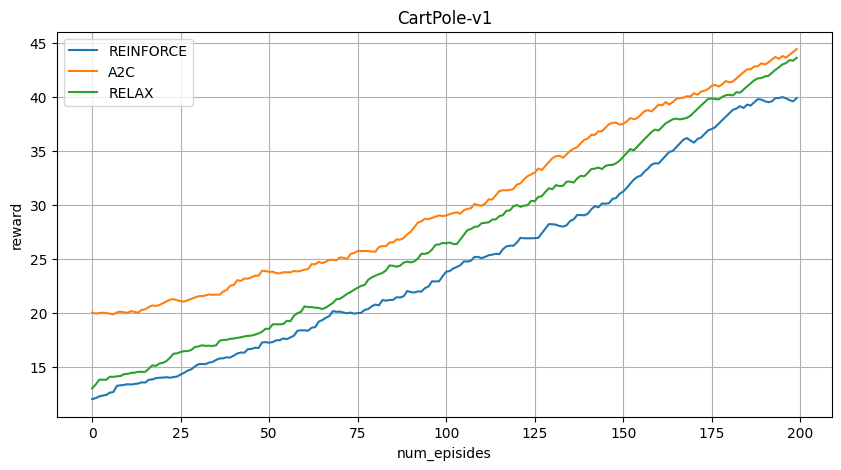

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 5))
for algorithm in ['REINFORCE', 'A2C', 'RELAX']:
    if algorithm in algorithm2rewards:
        ax.plot(algorithm2rewards[algorithm], label = algorithm)
ax.legend()
ax.set(
    title = 'CartPole-v1',
    ylabel = 'reward',
    xlabel = 'num_episides'
)
ax.grid()
plt.show()

In [20]:
algorithm2rewards = {}
for algorithm in ['REINFORCE', 'A2C']: #'RELAX', 
    algorithm2rewards[algorithm] = apply_benchmark(algorithm=algorithm,
                                                   env_name='Acrobot-v1',
                                                   max_episode=200,
                                                   max_steps = 650)

Episode 0	Last reward: -622.00	Average reward: -622.00
Episode 10	Last reward: -650.00	Average reward: -618.19
Episode 20	Last reward: -541.00	Average reward: -619.58
Episode 30	Last reward: -549.00	Average reward: -616.07
Episode 40	Last reward: -310.00	Average reward: -591.31
Episode 50	Last reward: -319.00	Average reward: -562.48
Episode 60	Last reward: -162.00	Average reward: -536.17
Episode 70	Last reward: -269.00	Average reward: -506.72
Episode 80	Last reward: -269.00	Average reward: -476.81
Episode 90	Last reward: -221.00	Average reward: -452.24
Episode 100	Last reward: -289.00	Average reward: -430.07
Episode 110	Last reward: -167.00	Average reward: -410.88
Episode 120	Last reward: -301.00	Average reward: -391.77
Episode 130	Last reward: -157.00	Average reward: -375.07
Episode 140	Last reward: -249.00	Average reward: -360.17
Episode 150	Last reward: -185.00	Average reward: -346.16
Episode 160	Last reward: -204.00	Average reward: -331.77
Episode 170	Last reward: -196.00	Average r

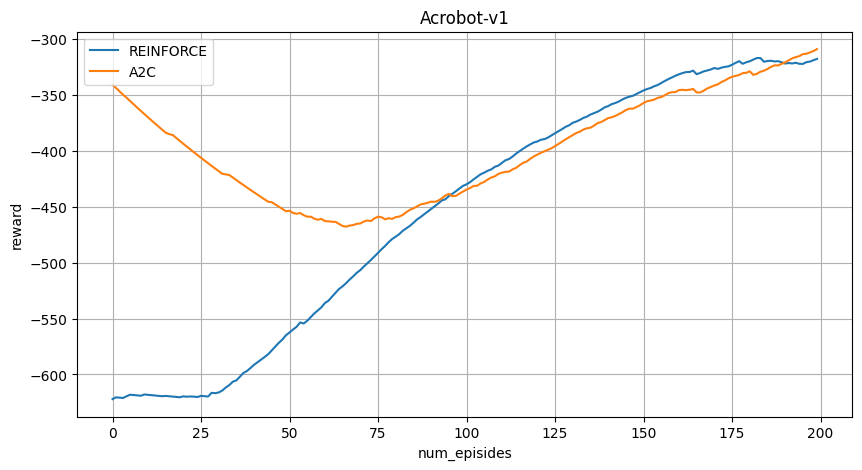

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 5))
for algorithm in ['REINFORCE', 'A2C', 'RELAX']:
    if algorithm in algorithm2rewards:
        ax.plot(algorithm2rewards[algorithm], label = algorithm)
ax.legend()
ax.set(
    title = 'Acrobot-v1',
    ylabel = 'reward',
    xlabel = 'num_episides'
)
ax.grid()
plt.show()

In [23]:
algorithm2rewards = {}
for algorithm in ['RELAX', 'REINFORCE', 'A2C']: 
    algorithm2rewards[algorithm] = apply_benchmark(algorithm=algorithm,
                                                   env_name='Taxi-v3',
                                                   max_episode=200,
                                                   max_steps = 30)

Episode 0	Last reward: -111.00	Average reward: -111.00
Episode 10	Last reward: -66.00	Average reward: -111.01
Episode 20	Last reward: -129.00	Average reward: -110.76
Episode 30	Last reward: -102.00	Average reward: -109.47
Episode 40	Last reward: -120.00	Average reward: -109.34
Episode 50	Last reward: -129.00	Average reward: -108.91
Episode 60	Last reward: -102.00	Average reward: -108.42
Episode 70	Last reward: -84.00	Average reward: -107.19
Episode 80	Last reward: -120.00	Average reward: -107.80
Episode 90	Last reward: -111.00	Average reward: -106.65
Episode 100	Last reward: -57.00	Average reward: -105.34
Episode 110	Last reward: -84.00	Average reward: -103.29
Episode 120	Last reward: -102.00	Average reward: -103.08
Episode 130	Last reward: -129.00	Average reward: -101.97
Episode 140	Last reward: -57.00	Average reward: -99.53
Episode 150	Last reward: -57.00	Average reward: -97.01
Episode 160	Last reward: -75.00	Average reward: -94.14
Episode 170	Last reward: -57.00	Average reward: -91.

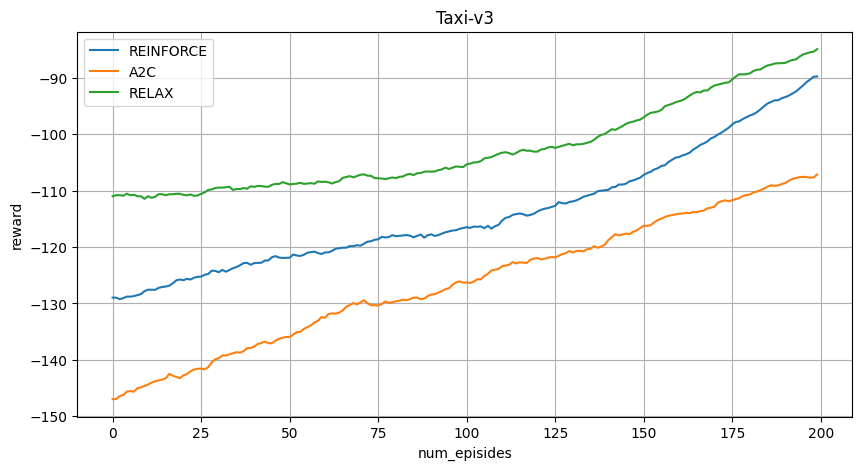

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 5))
for algorithm in ['REINFORCE', 'A2C', 'RELAX']:
    if algorithm in algorithm2rewards:
        ax.plot(algorithm2rewards[algorithm], label = algorithm)
ax.legend()
ax.set(
    title = 'Taxi-v3',
    ylabel = 'reward',
    xlabel = 'num_episides'
)
ax.grid()
plt.show()